In [53]:
import json

import pandas as pd

In [54]:
TARGET = 'reviewer_score'

Загружаем данные:

In [55]:
hotels_train = pd.read_csv('hotels_train.csv.zip')
hotels_test = pd.read_csv('hotels_test.csv.zip')
sample_submission = pd.read_csv('submission.csv.zip')

Для работы с признаками объединяем тренировочный и тестовый датасеты:

In [56]:
hotels_train['train'] = 1
hotels_test['train'] = 0
hotels = pd.concat([hotels_train, hotels_test])
hotels.reset_index(drop=True, inplace=True)

Освобождаем память:

In [50]:
del hotels_train
del hotels_test

1. Разведывательный анализ данных

#### 1.1. Устранение пропусков

Посмотрим на пропуски:

In [11]:
hotels.drop(columns=[TARGET]).isna().sum().sort_values(ascending=False)

lng                                           3268
lat                                           3268
hotel_address                                    0
positive_review                                  0
days_since_review                                0
tags                                             0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
total_number_of_reviews                          0
additional_number_of_scoring                     0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
train                                            0
dtype: int64

Для устранения пропусков создадим словари широты и долготы для каждого уникального адреса отеля для тех строк, в которых широта и долгота отсутствуют.

In [33]:
from geopy.geocoders import ArcGIS
from tqdm import tqdm

addresses = hotels[hotels.lat.isna()].hotel_address.values

locator = ArcGIS()
lng_dict = {}
lat_dict = {}

for address in tqdm(addresses):
    location = locator.geocode(address)
    if location is None:
        raise ValueError(f"Latitude and longitude for address {address} can't be found")
    if location.latitude is None:
        raise ValueError(f"Latitude and longitude for address {address} can't be found")
    lng_dict[address] = location.longitude
    lat_dict[address] = location.latitude

100%|██████████| 1614/1614 [16:24<00:00,  1.64it/s]


Заполняем пропуски значениями из словарей

In [57]:
missings_idx = hotels[hotels.lng.isna()].index
hotels.loc[missings_idx, 'lat'] = hotels.loc[missings_idx, 'hotel_address'].map(lat_dict)
hotels.loc[missings_idx, 'lng'] = hotels.loc[missings_idx, 'hotel_address'].map(lng_dict)

In [58]:
hotels.drop(columns=[TARGET]).isna().sum().sort_values(ascending=False)

hotel_address                                 0
positive_review                               0
lng                                           0
lat                                           0
days_since_review                             0
tags                                          0
total_number_of_reviews_reviewer_has_given    0
review_total_positive_word_counts             0
total_number_of_reviews                       0
additional_number_of_scoring                  0
review_total_negative_word_counts             0
negative_review                               0
reviewer_nationality                          0
hotel_name                                    0
average_score                                 0
review_date                                   0
train                                         0
dtype: int64

От пропусков избавились. Обратим внимание на признаки, представленные в виде строк:

Дополним датасет данными о стране и городе, в которых располагается отель

In [63]:
def get_country(address):
    country = address.split()[-1]
    if country == 'Kingdom':
        country = 'United Kingdom'
    return country

def get_city(address):
    address_parts = address.split()
    return (
        address_parts[-5]
        if address_parts[-1] == 'Kingdom'
        else address_parts[-2]
    )

In [65]:
hotels['hotel_country'] = hotels.hotel_address.apply(get_country)
hotels['hotel_city'] = hotels.hotel_address.apply(get_city)

In [66]:
hotels.hotel_country.value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [67]:
hotels.hotel_city.value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [69]:
hotels.drop(columns=[TARGET]).isna().sum().sum()

0

Пропусков нет

#### 1.2. Добавление признака расстояния от отеля до центра города, в котором он расположен

In [70]:
from geopy.distance import geodesic

In [78]:
def get_distance(lat1, lng1, lat2, lng2):
    return geodesic((lat1, lng1), (lat2, lng2)).kilometers

In [71]:
hotels['hotel_location'] = hotels.hotel_city + ',' + hotels.hotel_country

In [72]:
hotels.hotel_location

0         London,United Kingdom
1         London,United Kingdom
2                  Paris,France
3                  Paris,France
4         Amsterdam,Netherlands
                  ...          
515733              Milan,Italy
515734          Barcelona,Spain
515735           Vienna,Austria
515736              Milan,Italy
515737             Paris,France
Name: hotel_location, Length: 515738, dtype: object

In [74]:
hotels.hotel_location.value_counts()

London,United Kingdom    262301
Barcelona,Spain           60149
Paris,France              59928
Amsterdam,Netherlands     57214
Vienna,Austria            38939
Milan,Italy               37207
Name: hotel_location, dtype: int64

In [73]:
hotels_cities_centers_lats = {}
hotels_cities_centers_lngs = {}

for location in tqdm(hotels.hotel_location.unique()):
    city_center_coordinates = locator.geocode(location)
    hotels_cities_centers_lats[location] = city_center_coordinates.latitude
    hotels_cities_centers_lngs[location] = city_center_coordinates.longitude


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


In [75]:
hotels['city_center_lat'] = hotels['hotel_location'].map(hotels_cities_centers_lats)
hotels['city_center_lng'] = hotels['hotel_location'].map(hotels_cities_centers_lngs)


In [76]:
tqdm.pandas()

In [79]:
hotels['dist_to_center'] = hotels[['city_center_lat', 'city_center_lng', 'lat', 'lng']].progress_apply(
    lambda x: get_distance(
        x['city_center_lat'],
        x['city_center_lng'],
        x['lat'],
        x['lng']
    ),
    axis=1
)

100%|██████████| 515738/515738 [01:47<00:00, 4798.02it/s]


#### 1.3. Работа с признаками, представленными строковыми данными

In [81]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   hotel_address         515738 non-null  object
 1   review_date           515738 non-null  object
 2   hotel_name            515738 non-null  object
 3   reviewer_nationality  515738 non-null  object
 4   negative_review       515738 non-null  object
 5   positive_review       515738 non-null  object
 6   tags                  515738 non-null  object
 7   days_since_review     515738 non-null  object
 8   hotel_country         515738 non-null  object
 9   hotel_city            515738 non-null  object
 10  hotel_location        515738 non-null  object
dtypes: object(11)
memory usage: 43.3+ MB


#### 1.3.1. Обработка hotel_address

Посмотрим на количество уникальных значений адреса и названия отеля:

In [87]:
hotels[['hotel_address', 'hotel_name']].nunique()

hotel_address    1493
hotel_name       1492
dtype: int64

Видим, что количество уникальных значений адресов и названий отелей практически совпадает. Разница в 1 единицу на весь датасет в пользу названий отелей. От признака адреса теперь можно избавиться. Но снасала выясним, с чем связана эта разница.

In [88]:
hotels.groupby('hotel_address')[['hotel_name']].nunique().sort_values(by='hotel_name', ascending=False).head(1)

,hotel_name
hotel_address,
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,2


Видим, что по адресу '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom' значатся два различных отеля. Посмотрим на них:

In [89]:
hotels[hotels.hotel_address == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'].hotel_name.unique()

array(['The Grand at Trafalgar Square',
       'Club Quarters Hotel Trafalgar Square'], dtype=object)

Видим два названия отеля по этому адресу. Проверим, а есть ли другие адреса для таких названий отелей.

In [90]:
hotels[hotels.hotel_name == 'The Grand at Trafalgar Square'].hotel_address.unique()


array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

In [91]:
hotels[hotels.hotel_name == 'Club Quarters Hotel Trafalgar Square'].hotel_address.unique()

array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

Да, видим, что других адресов у этих отелей нет и действительно по одному адресу находятся два разных отеля. Проверка в интернет показала, что оба отеля реальные и работают.

Это говорит о том, что:
1. Название отеля лучше определяет его чем адрес;
2. От адреса можно избавиться.

Сделаем это:

In [92]:
hotels.drop(columns=['hotel_address'], inplace=True)

#### 1.3.2. Теперь поработаем с review_date:

In [94]:
hotels.review_date = pd.to_datetime(hotels.review_date)
hotels.review_date.describe(datetime_is_numeric=True)

count                           515738
mean     2016-08-13 13:23:37.096277760
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Лучше этот признак сразу разбить на три числовых:
1. year - год;
2. month - месяц;
3. day - день,

а затем избавиться от него.

Сделаем это:

In [96]:
hotels['year'] = hotels.review_date.dt.year
hotels['month'] = hotels.review_date.dt.month
hotels['day'] = hotels.review_date.dt.day

In [97]:
hotels.drop(columns=['review_date'], inplace=True)

#### 1.3.3. Обработка названия отеля:

Посмотрим еще раз на количество уникальных значений этого признака:

In [99]:
hotels.hotel_name.nunique()

1492

Уникальных значений слишком много для применения OneHotEncoder. Сделаем этот признак категориальным:

In [100]:
hotels.hotel_name = hotels.hotel_name.astype('category')

Посмотрим на частоты упоминаний названий отелей в датасете:

In [104]:
hotel_reviews_freqs = hotels.hotel_name.value_counts(normalize=True) * 100
hotel_reviews_freqs

Britannia International Hotel Canary Wharf           0.928572
Strand Palace Hotel                                  0.825225
Park Plaza Westminster Bridge London                 0.808356
Copthorne Tara Hotel London Kensington               0.693763
DoubleTree by Hilton Hotel London Tower of London    0.622797
                                                       ...   
Hotel Eitlj rg                                       0.002327
Le Lavoisier                                         0.002327
Hotel Wagner                                         0.001939
Mercure Paris Porte d Orleans                        0.001939
Hotel Gallitzinberg                                  0.001551
Name: hotel_name, Length: 1492, dtype: float64

Видим, что есть очень популярные отели, а есть те, по которым количество отзывов не велико. Добавим признак частот упоминания отелей:

In [105]:
hotels['hotel_revies_freq'] = hotels.hotel_name.map(hotel_reviews_freqs)

#### 1.3.4. Обработка национальности оставившего отзыв

Посмотрим на количество уникальных значений:

In [106]:
hotels.reviewer_nationality.nunique()

227

Посмотрим на их частоты:

In [167]:
hotels.reviewer_nationality.value_counts().head(60)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 Hong Kong                      3013
 

Видим, что разных национальностей много и встречаются многие из них часто, поэтому национальность оставившего обзор тоже приведем к категориальному типу:

In [107]:
hotels.reviewer_nationality = hotels.reviewer_nationality.astype('category')

#### 1.3.5. Обработка отзывов

Проведем оценку эмоциональной окраски отзывов:

Для начала посмотрим на частоты отрицательных и положительных отзывов:

In [109]:
hotels.negative_review.value_counts().head()

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
Name: negative_review, dtype: int64

Сразу видим необходимость избавиться от лишних пробелов в начале и конце отзывов, а также приведения текста к нижнему регистру. Сделаем это:

In [118]:
hotels.negative_review = hotels.negative_review.apply(str.strip)
hotels.negative_review = hotels.negative_review.apply(str.lower)
hotels.positive_review = hotels.positive_review.apply(str.strip)
hotels.positive_review = hotels.positive_review.apply(str.lower)


Посмотрим частоты отзывов еще раз:

In [125]:
hotels.negative_review.value_counts().head(60)


no negative                        127890
nothing                             21185
n a                                  1815
none                                 1501
                                      849
nothing really                        656
small room                            570
all good                              545
breakfast                             545
no complaints                         523
location                              502
nothing at all                        467
everything                            420
nothing to dislike                    373
price                                 348
nil                                   332
small rooms                           307
everything was perfect                276
na                                    272
can t think of anything               250
leaving                               244
absolutely nothing                    242
everything was great                  222
expensive                         

В негативных отзывах видим, что 'no negative', 'nothing', 'n a', 'none', пустая строка, 'nothing really', 'no complaints', 'nothing at all',  'nothing to dislike ', 'nil', 'na', 'can t think of anything', 'absolutely nothing', 'nothing to complain about', 'no', 'nothing not to like', 'see above', 'non', 'nothing in particular', 'nothing comes to mind', 'there was nothing i didn t like' носят положительный характер. Приведем их к значению everything is great.

А что с позитивными отзывами? Посмотрим:

In [126]:
hotels.positive_review.value_counts().head(60)

no positive                        35946
location                           11945
everything                          3314
nothing                             1731
great location                      1687
the location                        1606
good location                       1496
breakfast                            795
friendly staff                       733
excellent location                   639
staff                                553
location and staff                   452
location staff                       432
location location location           345
location was great                   328
everything was perfect               316
good breakfast                       316
location was good                    312
comfy bed                            303
perfect location                     287
the staff                            281
location is great                    280
location is good                     256
all                                  250
clean           

Здесь 'no positive' и пустые строки приведем к отрицательному варианту 'everything is bad'.

In [132]:
negative_to_positive = {
    'no negative',
    'nothing',
    'n a',
    'none',
    '',
    'nothing really',
    'no complaints',
    'nothing at all',
    'nothing to dislike ',
    'nil',
    'na',
    'can t think of anything',
    'absolutely nothing',
    'nothing to complain about',
    'no',
    'nothing not to like',
    'see above',
    'non',
    'nothing in particular',
    'nothing comes to mind',
    'there was nothing i didn t like'
}

In [133]:
hotels.negative_review = hotels.negative_review.apply(
    lambda x: 'everithing is great' if x in negative_to_positive else x
)

In [134]:
hotels.positive_review = hotels.positive_review.apply(
    lambda x: 'everithing is bad' if x in {'', 'no positive'} else x
)

Теперь добавим признаки эмоционально окраски используя nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [138]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [136]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alexey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [139]:
# создаем два экземпляра анализатора, чтобы разделить лексикон
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

print('Оценка эмоциональной окраски негативных отзывов:')
hotels['neg_scores'] = hotels['negative_review'].progress_apply(
    lambda x: sia_neg.polarity_scores(x))
print('Оценка эмоциональной окраски негативных отзывов:')
hotels['pos_scores'] = hotels['positive_review'].progress_apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
print('Формирование новых признаков:')
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].progress_apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].progress_apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].progress_apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].progress_apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].progress_apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].progress_apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].progress_apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].progress_apply(
    lambda x: x['compound'])


Оценка эмоциональной окраски негативных отзывов:


100%|██████████| 515738/515738 [01:44<00:00, 4922.75it/s]


Оценка эмоциональной окраски негативных отзывов:


100%|██████████| 515738/515738 [01:42<00:00, 5015.33it/s]


Формирование новых признаков:


100%|██████████| 515738/515738 [00:00<00:00, 1040313.81it/s]


Добавим информацию о частотах отзывов (есть часто повторяющиеся, а есть уникальные)

In [140]:
nr_frequencies = hotels.negative_review.value_counts(normalize=True)
nr_frequencies_dict = dict(zip(nr_frequencies.index, nr_frequencies.values))
hotels['nr_frequency'] = hotels.negative_review.map(nr_frequencies_dict)

pr_frequencies = hotels.positive_review.value_counts(normalize=True)
pr_frequencies_dict = dict(zip(pr_frequencies.index, pr_frequencies.values))
hotels['pr_frequency'] = hotels.positive_review.map(pr_frequencies_dict)

Удалим признаки с отзывами

In [141]:
hotels.drop(columns=['negative_review', 'positive_review'], inplace=True)

#### 1.3.6. Обработка признака days_since_rewiev

In [152]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

#### 1.3.7. Обработка признака tags

Видим структуру, похожую на список строковых значений. Преобразуем данные в список строк:

In [181]:
hotels.tags = hotels.tags.apply(lambda x: x[2:-2].strip().split(' \', \' '))

Посмотрим на частоты тегов в разрезе количества:

In [218]:
hotels.tags.apply(len).value_counts().sort_index(ascending=False)

6       755
5    297823
4    211564
3      5505
2        85
1         6
Name: tags, dtype: int64

Видим, что максимально могут быть 6 тегов в одном отзыве. Посмотрим на такие теги:

In [220]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)
hotels[hotels.tags.apply(len) == 6].tags.head(60)

698                         [With a pet, Leisure trip, Solo traveler, Standard Double Room, Stayed 2 nights, Submitted from a mobile device]
1276                                  [With a pet, Leisure trip, Group, Superior Twin Room, Stayed 3 nights, Submitted from a mobile device]
1407                    [With a pet, Leisure trip, Family with young children, Family Room, Stayed 3 nights, Submitted from a mobile device]
2102               [With a pet, Business trip, Couple, King Room with City View Top floors, Stayed 2 nights, Submitted from a mobile device]
2281                                             [With a pet, Leisure trip, Group, 2 rooms, Stayed 3 nights, Submitted from a mobile device]
2827            [With a pet, Leisure trip, Family with young children, Double or Twin Room, Stayed 5 nights, Submitted from a mobile device]
6175                        [With a pet, Leisure trip, Group, Double or Twin Room with View, Stayed 1 night, Submitted from a mobile device]
6314         

Посмотрим на частоты первого из таких тегов:

In [221]:
hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[0]).value_counts()

With a pet    755
Name: tags, dtype: int64

Видим, что первым может идти только тег 'With a pet', значающий, что постоялец/постояльци приезжали с домашним животным. Создадим соответствующий бинарный признак:

In [222]:
def get_with_a_pet(tags):
    return next((1 for tag in tags if tag == 'With a pet'), 0)

In [223]:
hotels['with_a_pet'] = hotels.tags.progress_apply(get_with_a_pet)

100%|██████████| 515738/515738 [00:00<00:00, 558816.08it/s]


Посмотрим на частоты этого признака:

In [233]:
hotels.with_a_pet.value_counts()

0    514333
1      1405
Name: with_a_pet, dtype: int64

Посмотрим на частоты второго элемента списка тегов:

In [224]:
hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[1]).value_counts()


Leisure trip     661
Business trip     94
Name: tags, dtype: int64

Видим, что есть только 2 значения: Leisure trip и Business trip. И тот и другой содержат слово trip. Создадим на основе этого признак trip_type:

In [234]:
def get_trip_type(tags):
    return next((tag for tag in tags if tag in ['Leisure trip', 'Business trip']), 'Unknown')

In [235]:
hotels['trip_type'] = hotels.tags.progress_apply(get_trip_type)

100%|██████████| 515738/515738 [00:00<00:00, 710276.02it/s]


Переведем этот признак к категориальному типу и посмотрим на частоты этого признака:

In [241]:
hotels.trip_type = hotels.trip_type.astype('category')
hotels.trip_type.value_counts()

Leisure trip     417778
Business trip     82939
Unknown           15021
Name: trip_type, dtype: int64

Посмотрим на частоты третьего элемента:

In [237]:
hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[2]).value_counts()

Couple                        398
Family with young children    131
Solo traveler                 101
Group                          84
Family with older children     41
Name: tags, dtype: int64

Видим, что эта часть даёт признак типа гостей. Соберем различные варианты в множество и создадим новый признак guest_type:

In [239]:
guest_types = set(hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[2]).unique())

def get_guest_type(tags):
    return next((tag for tag in tags if tag in guest_types), 'Unknown')

hotels['guest_type'] = hotels.tags.progress_apply(get_guest_type)

100%|██████████| 515738/515738 [00:00<00:00, 550428.63it/s]


Сделаем этот признак категориальным и посмотрим на частоты его значений:

In [243]:
hotels.guest_type = hotels.trip_type.astype('category')
hotels.guest_type.value_counts()

Leisure trip     417778
Business trip     82939
Unknown           15021
Name: guest_type, dtype: int64

Посмотрим на частоты в четвертом элементе тегов:

In [247]:
fourth_tag_elements = hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[3])

In [248]:
fourth_tag_elements.value_counts()

Superior Double Room             49
Standard Double Room             48
Double or Twin Room              48
Double Room                      40
Deluxe Double Room               29
                                 ..
Deluxe Room Barlow Wing           1
Superior Triple Room              1
Executive Room with City View     1
Sextuple Room                     1
Deluxe Studio Suite               1
Name: tags, Length: 209, dtype: int64

Похоже на то, что этот признак отвечает за тип номера и обязательно содержит Room. Проверим это:

In [250]:
room_in_tag_mask = fourth_tag_elements.apply(lambda x: 'Room' in x)
fourth_tag_elements[~room_in_tag_mask].value_counts()

2 rooms                                             28
Junior Suite                                         9
Suite                                                4
Studio                                               3
Suite with Spa Access 2 Adults                       2
Chelsea Double Suite                                 2
Standard                                             2
Deluxe Junior Suite                                  2
Family Suite                                         1
Junior Triple Suite                                  1
Junior Suite Courtyard                               1
Junior Suite 3 Adults                                1
Duplex Suite with Spa Access                         1
Cool Corner Suite                                    1
Suite with Terrace                                   1
Junior Suite with Executive Lounge Access            1
Gallery Suite                                        1
Deluxe                                               1
Large Gard

Видим, что нужно добавить к Room еще rooms, Suite и Studio для более точного детектирования признака типа номера room_type. Создадим этот признак:

In [252]:
room_type_features = [
    'Room',
    'rooms',
    'Suite',
    'Studio'
]

def room_type_present(tag):
    return any(room_type in tag for room_type in room_type_features)

def get_room_type(tags):
    return next((tag for tag in tags if room_type_present(tag)), 'Unknown')

hotels['room_type'] = hotels.tags.progress_apply(get_room_type)

hotels.room_type.value_counts()

100%|██████████| 515738/515738 [00:01<00:00, 321199.68it/s]


Double Room                                  35207
Standard Double Room                         32248
Superior Double Room                         31393
Deluxe Double Room                           24823
Double or Twin Room                          22393
                                             ...  
Suite with Club Lounge Access                    1
Superior Suite 4 Adults                          1
One Bedroom Suite with Courtyard View            1
Family Room Two connecting Rooms 3 Adults        1
King Master Suite                                1
Name: room_type, Length: 2190, dtype: int64

Видим, что вариантов масса, поэтому приведем этот признак к категориальному типу:

In [253]:
hotels.room_type = hotels.room_type.astype('category')

Проанализируем пятый элемент тегов:

In [254]:
hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[4]).value_counts()


Stayed 1 night      311
Stayed 2 nights     197
Stayed 3 nights     127
Stayed 4 nights      59
Stayed 5 nights      28
Stayed 7 nights      11
Stayed 6 nights      10
Stayed 8 nights       3
Stayed 9 nights       2
Stayed 10 nights      2
Stayed 11 nights      2
Stayed 20 nights      1
Stayed 14 nights      1
Stayed 18 nights      1
Name: tags, dtype: int64

Видим, что это признак, обозначающий количество ночей, на которые заселялись гости. Выделим его, ставя 0 там, где этот тег отсутствует:

In [255]:
def get_nights_count(tags):
    return next((int(tag.split()[1]) for tag in tags if 'Stayed' in tag), 0)

In [257]:
hotels['nights_count'] = hotels.tags.progress_apply(get_nights_count)

100%|██████████| 515738/515738 [00:00<00:00, 552947.31it/s]


Посмотрим на частоты этого признака после извлечения:

In [259]:
hotels.nights_count.value_counts()


1     193645
2     133937
3      95821
4      47817
5      20845
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
30        11
27        11
22        10
23        10
28         7
26         7
25         7
24         6
29         5
31         1
Name: nights_count, dtype: int64

Видим, что нули есть, но их относительно немного.

Проанализируем 6-й элемент тегов:

In [260]:
hotels[hotels.tags.apply(len) == 6].tags.apply(lambda x: x[5]).value_counts()

Submitted from a mobile device    755
Name: tags, dtype: int64

Видим, что это признак того, что отзыв отправлен с мобильного устройства.

Превратим наличие или отсутствие тега "Submitted from a mobile device" в бинарный признак from_mobile

In [261]:
def get_from_mobile(tags):
    return next((1 for tag in tags if tag == 'Submitted from a mobile device'), 0)


In [262]:
hotels['from_mobile'] = hotels.tags.progress_apply(get_from_mobile)

100%|██████████| 515738/515738 [00:00<00:00, 564793.06it/s]


In [263]:
hotels.from_mobile.value_counts()

1    307640
0    208098
Name: from_mobile, dtype: int64

#### 1.3.8. Преобразование строковых признаков в категориальные, удаление лишних признаков

Посмотрим на оставшиеся строковые признаки:

In [265]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tags            515738 non-null  object
 1   hotel_country   515738 non-null  object
 2   hotel_city      515738 non-null  object
 3   hotel_location  515738 non-null  object
 4   neg_scores      515738 non-null  object
 5   pos_scores      515738 non-null  object
dtypes: object(6)
memory usage: 23.6+ MB


### 2. Отбор признаков

Переведем hotel_country, hotel_city к категориальному типу:

In [266]:
hotels.hotel_country = hotels.hotel_country.astype('category')
hotels.hotel_city = hotels.hotel_city.astype('category')

Для тестирования промежуточного результата избавимся от оставщихся строковых данных.

In [267]:
hotels = hotels.select_dtypes([], ['object'])

Перед отбором признаков проверим датасет на пропуски:

In [269]:
hotels.drop(columns=[TARGET]).isna().sum().sum()

0

Удалим промежуточные признаки city_center_lat, city_center_lng, необходимость в которых отпала после вычисления расстояния от отеля до центра города

In [281]:
hotels.drop(columns=[
    'city_center_lat',
    'city_center_lng',
], inplace=True)

Проведем анализ мультиколлинеарности признаков

In [283]:
import seaborn as sns

In [284]:
pd.set_option('display.max_rows', 100)

In [304]:
def show_corr(min_corr = 0.75, show_heatmap=True):
    corr = hotels.drop(columns=['train', TARGET]).corr(numeric_only=True)
    if show_heatmap:
        sns.set(rc={'figure.figsize':(20, 10)})
        ax = sns.heatmap(
            corr, 
            vmin=-1, 
            vmax=1, 
            center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
        );
    corr_unstack = corr.abs().unstack().reset_index()
    corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
    mask = corr_unstack['level_0'] != corr_unstack['level_1']
    corr_unstack = corr_unstack[mask]
    corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
    corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
    corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
    corr_unstack = corr_unstack.drop(['pr1'], axis=1)
    print('Наиболее высокая корреляция между признаками:')
    print(corr_unstack[corr_unstack[0] >= min_corr])

Посмотрим на корреляцию между признаками:

Наиболее высокая корреляция между признаками:
                          level_0                       level_1         0
13   additional_number_of_scoring             hotel_revies_freq  0.983634
160             days_since_review                          year  0.917266
391       n_review_sentiments_neu       n_review_sentiments_pos  0.892428
328             hotel_revies_freq       total_number_of_reviews  0.832445
75        total_number_of_reviews  additional_number_of_scoring  0.824884
441  n_review_sentiments_compound       n_review_sentiments_pos  0.779952
495       p_review_sentiments_neu       p_review_sentiments_pos  0.759999


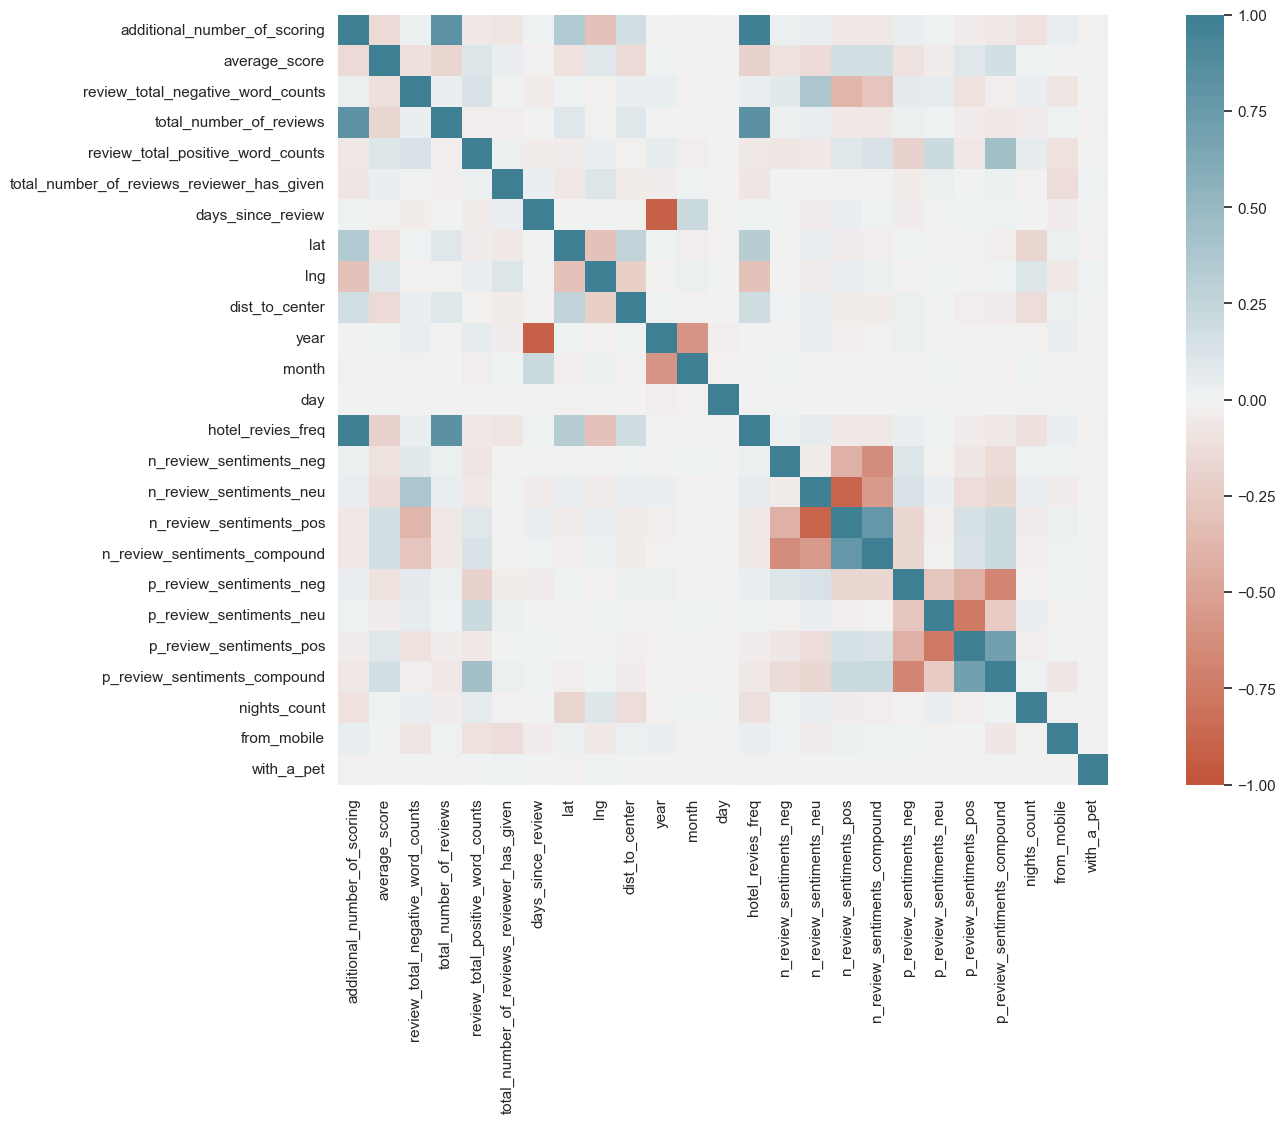

In [294]:
show_corr()

Удалим часть сильно скорррелированных признаков:

In [300]:
hotels.drop(columns=[
    'nr_frequency',
    'pr_frequency',
    'year',
    'hotel_revies_freq',
    'n_review_sentiments_neu',
    'total_number_of_reviews',
    'p_review_sentiments_neu',
    'n_review_sentiments_compound'
], inplace=True)

Посмотрим на корреляции еще раз:

In [305]:
show_corr(show_heatmap=False)

Наиболее высокая корреляция между признаками:
Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []


Видим, что сильно скоррелированных признаков не осталось.

### 3. Анализ целевой переменной

Посмотрим на то, как целевая переменная представлена в sample_submission:

In [311]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


Видим, что переменная представлена в целочисленном виде. Посмотрим подробнее:

In [312]:
sample_submission.reviewer_score.describe()

count    128935.000000
mean          5.504270
std           2.873259
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: reviewer_score, dtype: float64

Видим, что минимальная оценцка 1, а максимальная 10. Однако при score более 44 по такому предсказанию, ориентироваться на него не стоит.

Посмотрим на целевую переменную в тренировочном датасете:

In [308]:
hotels[hotels.train == 1][TARGET].describe()

count    386803.000000
mean          8.396906
std           1.636090
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

<AxesSubplot: xlabel='reviewer_score', ylabel='Density'>

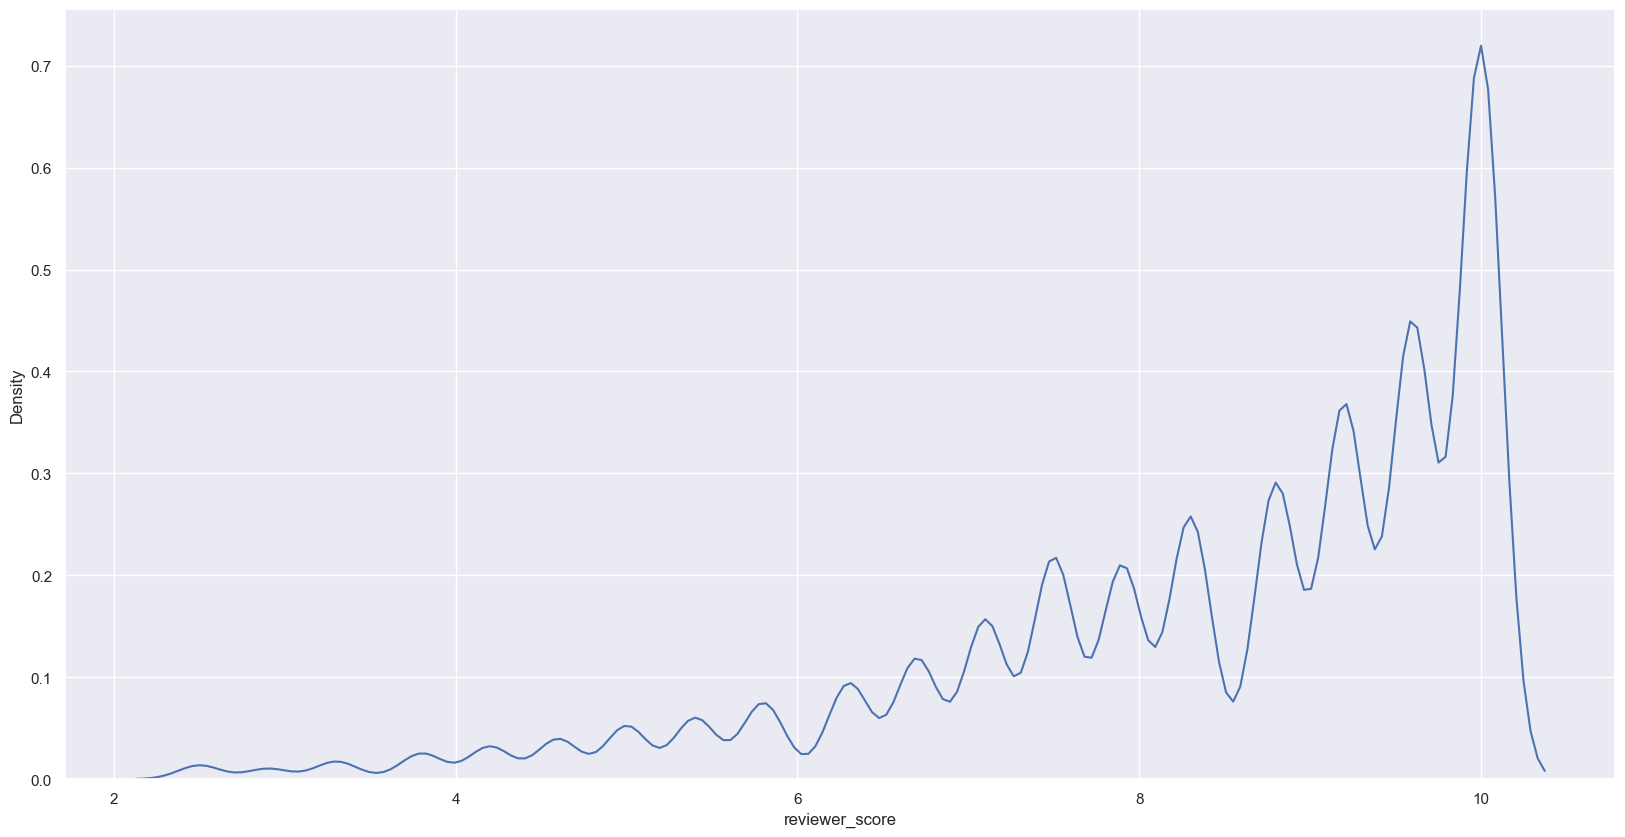

In [309]:
sns.kdeplot(hotels[hotels.train == 1][TARGET])

In [ ]:
sns.boxplot()

Проведем обучение модели с помощью LAMA

In [319]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import numpy as np

# Определение констант для lightautoml
N_THREADS = 12
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 200000 # equal to 10 hours
TARGET_NAME = 'reviewer_score'

np.random.seed(RANDOM_STATE)

In [320]:
train_data = hotels[hotels.train == 1].drop(columns=['train'])
test_data = hotels[hotels.train == 0].drop(columns=['train'])

In [321]:
from sklearn.model_selection import train_test_split

In [322]:
# разбиение на тренировочную и валидационную модели
# tr_data - тренеровочные данные
# te_data - холдаут

tr_data, te_data = train_test_split(
    train_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)


In [323]:
# Task - объект из lightautoml
# Определяем какую задачу мы решаем: бинарную 'binary', регрессии 'reg', мультикласс 'multiclass'
# В данном случае регрессия - так как предсказываем вещественное число

task = Task('reg', loss='mae', metric='mae')

# какая колонка является целевой? и какие колонки лишние
roles = {
    'target': TARGET_NAME,
    'drop': []
}

# Создаем объект TabularAutoML

automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)


# Начало обучения модели (на каких данных обучаем, какой target, уровень отображения)
# После выполнения обучения мы получаем Out OF Folde пердсказание

oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)


[14:35:15] Stdout logging level is INFO.
[14:35:15] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:35:15] Task: reg

[14:35:15] Start automl preset with listed constraints:
[14:35:15] - time: 200000.00 seconds
[14:35:15] - CPU: 12 cores
[14:35:15] - memory: 16 GB

[14:35:15] Train data shape: (270762, 27)



/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarnin

[14:35:28] Layer 1 train process start. Time left 199986.81 secs
[14:35:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:37:42] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.9201184528247484
[14:37:42] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:37:42] Time left 199852.97 secs



/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarnin

[14:38:31] Selector_LightGBM fitting and predicting completed
[14:38:44] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[14:53:10] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.8280448119044626
[14:53:10] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[14:53:10] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[14:59:22] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[14:59:22] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:12:53] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.8277943623670794
[15:12:53] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:12:53] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


[15:14:42] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.8288178349446395
[15:14:42] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:14:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric perio

[15:19:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:19:49] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


[15:22:27] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.8280104385970938
[15:22:27] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[15:22:27] Time left 197167.76 secs

[15:22:27] Layer 1 training completed.

[15:22:27] Blending: optimization starts with equal weights and score -0.8319554023359954
[15:22:28] Blending: iteration 0: score = -0.825983609883205, weights = [0.         0.2290154  0.32820553 0.14306954 0.2997096 ]
[15:22:28] Blending: iteration 1: score = -0.825961162949916, weights = [0.         0.21464776 0.354009   0.0849406  0.34640265]
[15:22:29] Blending: iteration 2: score = -0.8259559635790016, weights = [0.         0.21763274 0.3546664  0.0620648  0.36563608]
[15:22:29] Blending: iteration 3: score = -0.825955814405325, weights = [0.         0.21680626 0.35568103 0.06134424 0.3661685 ]
[15:22:30] Blending: iteration 4: score = -0.8259556863561394, weights = [0.         0.21712503 0.355692   0.06065777 0.36652526]
[15:22:30] Automl

CPU times: user 230 ms, sys: 3.63 ms, total: 234 ms
Wall time: 233 ms


<AxesSubplot: xlabel='Feature'>

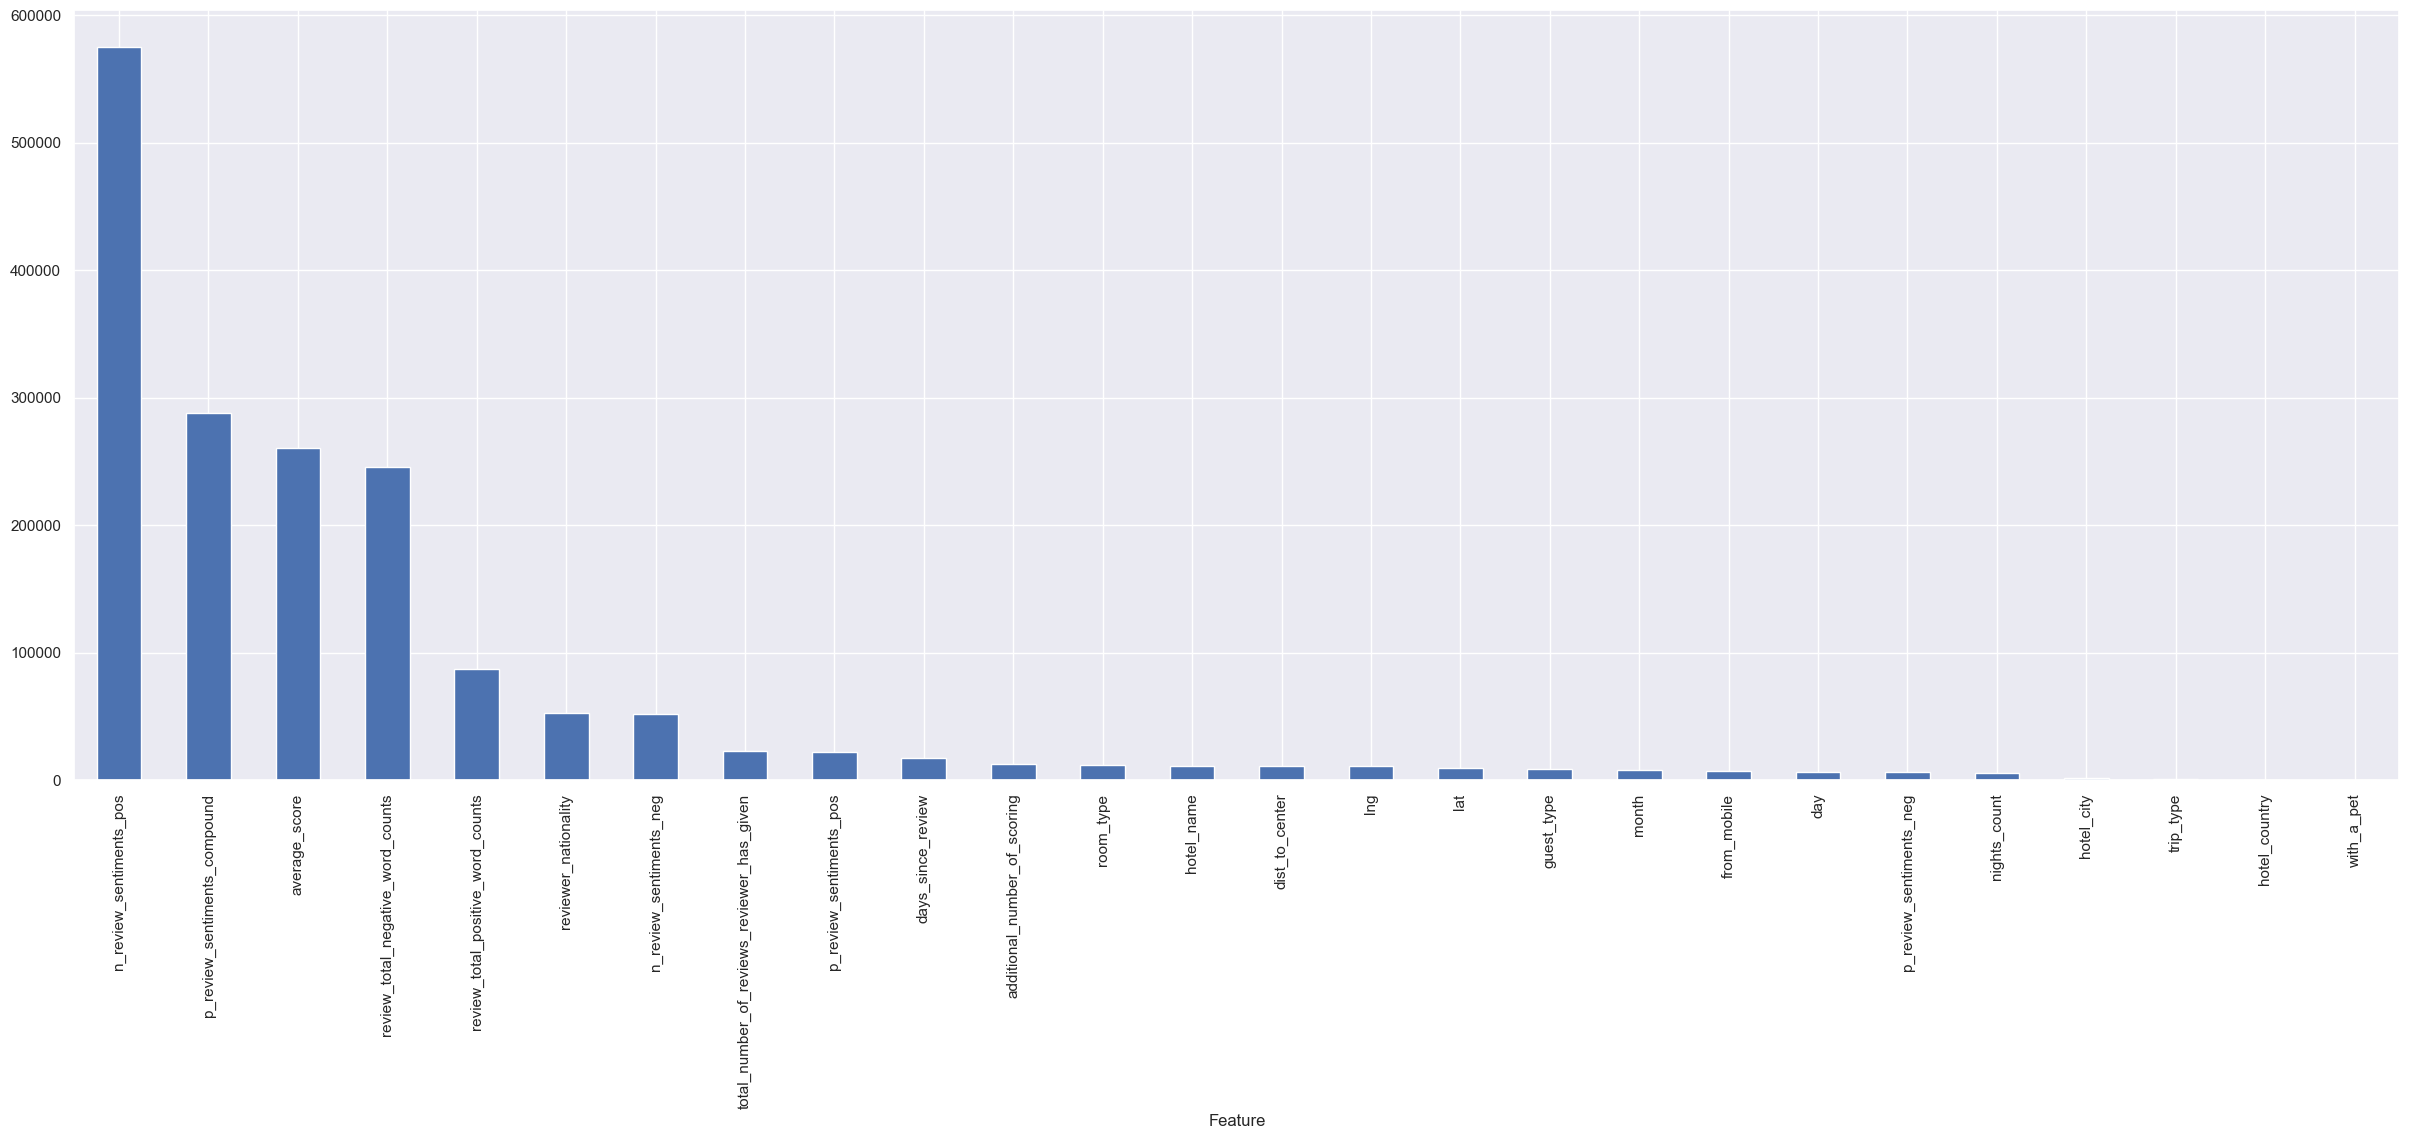

In [324]:
%%time
# Оцениваем важность признаков в графическом виде
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [325]:
# Получаем предсказание на валидационой выборке с помощью функции automl.predict
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5.2227993],
       [8.134073 ],
       [9.373009 ],
       ...,
       [9.622196 ],
       [7.631895 ],
       [9.852285 ]], dtype=float32)
Shape = (116041, 1)


In [326]:
from sklearn import metrics  # инструменты для оценки точности модели
#print(f'TRAIN  score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print('MAPE:', metrics.mean_absolute_percentage_error(
    te_data[TARGET_NAME].values, te_pred.data[:, 0]))


MAPE: 0.12104257245207856


In [327]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')


Prediction for te_data:
array([[8.785935 ],
       [7.7450438],
       [8.010721 ],
       ...,
       [8.197106 ],
       [9.788731 ],
       [7.775855 ]], dtype=float32)
Shape = (128935, 1)


In [330]:
sample_submission[TARGET_NAME] = test_pred.data[:, 0]
sample_submission.to_csv('lightautoml_tabularautoml_01.csv', index = False)

Округляем до целых в большу сторону

In [350]:
test_pred.data[:, 0].round().astype(np.uint8)

array([ 9,  8,  8, ...,  8, 10,  8], dtype=uint8)

In [351]:
sample_submission[TARGET_NAME] = test_pred.data[:, 0].round().astype(np.uint8)
sample_submission.to_csv('lightautoml_tabularautoml_02_int.csv', index=False)

В соревновании достигнута позиция 31 с оценкой 12.22017